Necessary Imports

In [0]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Image reading and display

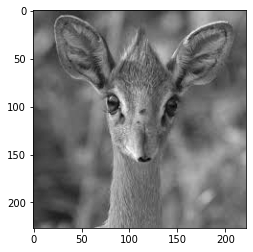

(227, 222)

In [0]:
imagePath='/content/image1.jpg'
img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img, cmap='gray')
plt.show()
img.shape

Convolution layer class

In [0]:
class Convolution_Operation:
  
  def __init__(self, Num_kernels, kernel_size):

    # Total Number of filters
    self.Num_kernels = Num_kernels 
    
    #Filter size (x,y)
    self.kernel_size = kernel_size 
    
    # initializing with random values and normalizing convoultion filter / kernel
    self.conv_filter = np.random.randn(Num_kernels, kernel_size, kernel_size) / (kernel_size * kernel_size) 

  
  # using generators on image region
  def Image_region(self, img): 
    height, width = img.shape 
    self.image = img 

    # conv output shape (n-f+1) in patches
    for j in range(height - self.kernel_size + 1):
      for k in range(width - self.kernel_size +1):
        image_patch = img[ j : ( j + self.kernel_size), k : ( k + self.kernel_size) ] 
        yield image_patch, j, k

  # Implementing Forward Propogation using generator by getting image in patches
  def forward_propogation(self, img):
    height, width = img.shape 
    conv_output = np.zeros( ( height - self.kernel_size + 1, width - self.kernel_size + 1, self.Num_kernels ) )
    
    # Getting image patches from image
    for image_patch, j, k in self.Image_region(img):
      conv_output[j, k] = np.sum( image_patch * self.conv_filter, axis =(1,2))
    return conv_output  
  
  # Implementing Backward Propagation, the argument "dervLayer_dOut", 
  # is the output from the maxpool backpropogation. 
  def back_propogation(self, dervLayer_dOut, learning_rate):
    dervLayer_dF_parameters = np.zeros(self.conv_filter.shape)
    
    for image_patch, i, j in self.Image_region(self.image):
      for k in range(self.Num_kernels):
        dervLayer_dF_parameters[k] += image_patch * dervLayer_dOut[i,j,k]

    # Kernel / Conv Filter weights / Parameters update
    self.conv_filter -= learning_rate * dervLayer_dF_parameters
    return dervLayer_dF_parameters     

(221, 216, 18)

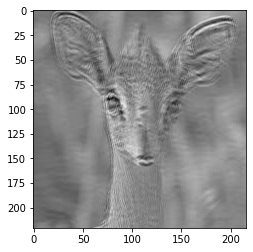

In [0]:
# Number of filters/kernels : 18
# Kernel / Filter size : 7  i.e. (7x7) 
convolution_Obj = Convolution_Operation(18, 7)   

'''
Applying Forward Propogation on image of shape with filters (227,222) * (18, 7x7)  
As the Original Shape was (227,222), after applying the forward Prop resultant shape
will be of (n+f-1) i.e. 227-7+1=221 , 222-7+1=216, #filters : 18 ==> (221, 216, 18)
'''
Features_After_Applying_Convolution = convolution_Obj.forward_propogation(img)
display(Features_After_Applying_Convolution.shape)

# Plotting the Result
plt.imshow(Features_After_Applying_Convolution[:,:,17], cmap='gray')
plt.show()

In [0]:
class Max_Pooling:
  
  # Defining filter size for performing max pooling
  def __init__(self, filter_size):
    self.filter_size = filter_size

  # Using generators on image region
  def Image_Region(self, img):
  
    # Resultant image shape after applying max pooling 
    output_height = img.shape[0] // self.filter_size
    output_width = img.shape[1] // self.filter_size
    self.img = img

    for i in range(output_height):
      for j in range(output_width):
        image_patch = img[(i * self.filter_size) : (i * self.filter_size + self.filter_size) , (j * self.filter_size) : (j * self.filter_size + self.filter_size) ] 
        yield image_patch, i, j

  
  # Implementing Forward Propogation for Max Pooling using generator by getting image in patches
  def forward_propogation(self, img):
    height, width, Num_Kernels = img.shape
    output = np.zeros(( height // self.filter_size, width // self.filter_size, Num_Kernels ))
    
    for image_patch, i, j in self.Image_Region(img):
      output[i, j] = np.amax( image_patch , axis =(0, 1))
    return output  
  
  
  # Implementing Backward Propagation, the argument "dervLayer_dOut", 
  # is the output from the Softmax Unit. 
  def back_propogation(self, dervLayer_dOut):
    dervLayer_dMaxPool = np.zeros(self.img.shape)
    
    for image_patch, i, j in self.Image_Region(self.img):
      height, width, Num_Kernels = image_patch.shape
      Maximum_value = np.amax(image_patch, axis=(0,1))

      for i1 in range(height):
        for j1 in range(width):
          for k  in range(Num_Kernels):
            if( image_patch[i1, j1, k] == Maximum_value[k]):
              dervLayer_dMaxPool[i * self.filter_size + i1, j + self.filter_size + j1, k] = dervLayer_dOut[i, j, k]

      return dervLayer_dMaxPool

  

(55, 54, 18)

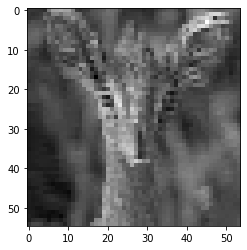

In [0]:
# Max Pooling of filter/ kernel : 4x4
Max_Pooling_Obj = Max_Pooling(4)

'''
Applying Forward Propogation for Max Pooling on image of shape with filters (221,216,18)  
output shape of the image after applying convolutional. After applying the Max Pool Forward Prop 
resultant shape will be of 221/4, 216/4, #filters : 18 ==> (55, 54, 18)
'''

Features_After_Max_Pooling = Max_Pooling_Obj.forward_propogation(Features_After_Applying_Convolution)
display(Features_After_Max_Pooling.shape)

plt.imshow(Features_After_Max_Pooling[:,:,17], cmap='gray')
plt.show()

In [0]:
class Softmax:

  def __init__(self, input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node) / input_node
    self.bias = np.zeros(softmax_node)
  
  # Implementing Forward Propogation Softmax, by flattening the input, and
  # then multiplying it by corresponding weights and adding the bais for prediction.
  def forward_propogation(self, img):
    self.original_image_shape = img.shape
    
    modified_image = img.flatten()
    self.modified_input = modified_image
    
    output_value = np.dot(modified_image, self.weight) + self.bias
    self.out = output_value
    
    # Transforming the output into Probabalistic Output
    exp_out = np.exp(output_value)
    return exp_out / np.sum(exp_out, axis = 0)

  
  # Implementing Backward Propagation  
  def back_propogation(self, dervLayer_dOut, learning_rate):

    for i, grad in enumerate(dervLayer_dOut):
      
      if grad == 0:
        continue
      
      # Calcutions For Back Propogation Softmax      
      transformation_eq = np.exp(self.out)
      s_total = np.sum(transformation_eq)

      #  Derivatives w.r.t out (z)
      dervY_dZ = -transformation_eq[i] * transformation_eq / (s_total ** 2)
      dervY_dZ[i] = transformation_eq[i] * (s_total - transformation_eq[i]) / (s_total **2)

      dervZ_dW = self.modified_input
      dervZ_dB = 1
      dervZ_d_inp = self.weight
      
      # Derivatives of Loss
      dervL_dZ = grad * dervY_dZ

      dervL_dW = dervZ_dW[np.newaxis].T @ dervL_dZ[np.newaxis]
      dervL_dB = dervL_dZ * dervZ_dB
      dervL_d_inp = dervZ_d_inp @ dervL_dZ

      # Updating Parameters i.e. Weight and Bias
      self.weight -= learning_rate * dervL_dW
      self.bias -= learning_rate * dervL_dB
      
      # In case of Back Prop the result will sent to Max Pool Unit, then 
      # to Convolution Unit
      return dervL_d_inp.reshape(self.original_image_shape)

In [0]:
# Arg: One Dimensional Image output by Max Pool Unit along with # of outputs
Softmax_Obj = Softmax(55 * 54 * 18, 10) 

# Here outout are random number just for showing working as no output classes are defined.
Softmax_Output = Softmax_Obj.forward_propogation(Features_After_Max_Pooling)
print("Random probability of an input image corresponding to the output class\n",Softmax_Output)

Random probability of an input image corresponding to the output class
 [0.10003337 0.09998801 0.09999744 0.10002159 0.09998617 0.09999377
 0.1000054  0.09993859 0.10003253 0.10000313]


In [0]:
# Now Applying all the major step of Concolution Neural Network on MNIST Dataset

from keras.datasets import mnist

# Loading the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Taking 1500 images for just testing the network
X_train = X_train[:1500]
X_test = X_test[:1500]
y_train = y_train[:1500]
y_test = y_test[:1500]

display(X_train.shape)


# Initializing all the Units

# Input Image shape (28 x 28 x 1)  ==> (26 x 26 x 8)  i.e. n-f+1 => (28-3+1, 28-3+1, #filters)
Convolution_Obj = Convolution_Operation(8,3)     

# Input Image shape (26 x 26 x 8)  ==> (13 x 13 x 8)  i.e (26/2, 26/2, #filters)
Max_Pooling_Obj = Max_Pooling(2)

# Input Flatten ( 1-Dimensional ) of Max_Pool Output, with 10 output class 0-9 digits 
Softmax_Obj = Softmax(13 * 13 * 8, 10)



(1500, 28, 28)

In [0]:
def CNN_Forward_Propogation_on_MNIST(image, label):
  '''
  Model Architecture is like:
  * 1 Convolution Layer
  * 1 Max Pool Layer
  * 1 Softmax Layer
  '''
  # Performing Foward Propogation For Each Unit
  output_convolution = Convolution_Obj.forward_propogation( (image / 255) - 0.5)
  output_maxpool = Max_Pooling_Obj.forward_propogation(output_convolution)
  output_softmax = Softmax_Obj.forward_propogation(output_maxpool)

  # Calculating Loss using Cross-Entrpoy
  cross_entropy_loss = -np.log( output_softmax[label] )

  # Calculating Accuracy
  accuracy = 1 if np.argmax(output_softmax) == label else 0

  return output_softmax, cross_entropy_loss, accuracy
  

In [0]:
def CNN_Model_Training(image, label, learning_rate= 0.005):

  # Perfomed Forward Propogation
  output_softmax, cross_entropy_loss, accuracy = CNN_Forward_Propogation_on_MNIST(image, label)
  
  # Calculating Derivative / Gradient for Output
  gradient = np.zeros(10)
  gradient[label] = -1 / output_softmax[label]

  # Performing Backward Propogation Each Unit
  gradient_back_propogation_Softmax = Softmax_Obj.back_propogation(gradient, learning_rate)
  gradient_back_propogation_Maxpool = Max_Pooling_Obj.back_propogation(gradient_back_propogation_Softmax)
  gradient_back_propogation_Convolution = Convolution_Obj.back_propogation(gradient_back_propogation_Maxpool, learning_rate)

  return cross_entropy_loss, accuracy

In [0]:
Num_of_Epochs = 4

# Running for 4 epochs
for epoch in range(Num_of_Epochs):
  print('\n*************** Epoch: '+ str(epoch+1) + ' ***************')

  # Shuffling the Training Set
  shuffle_data = np.random.permutation(len(X_train))
  X_train = X_train[shuffle_data]
  y_train = y_train[shuffle_data]

  # Intiliazing Variables For Monitoring The Loss and Accuracy
  Loss = 0
  Num_Correct_Prediction = 0

  #  Training The CNN Model
  for sample_Number, (train_Sample, sample_Label) in enumerate( zip(X_train, y_train) ):
    
    # 15 Batches of 100 images
    if(sample_Number % 100 == 0) :
      print('\nAverage Loss: {} and Accuracy: {}'.format(Loss/100, Num_Correct_Prediction/100), end="") 
      Loss = 0
      Num_Correct_Prediction = 0
    
    cross_entropy_loss, accuracy = CNN_Model_Training(train_Sample, sample_Label)
    Loss += cross_entropy_loss
    Num_Correct_Prediction += accuracy      
  print("")


*************** Epoch: 1 ***************

Average Loss: 0.0 and Accuracy: 0.0
Average Loss: 2.2770548728053406 and Accuracy: 0.17
Average Loss: 2.2023438778863293 and Accuracy: 0.28
Average Loss: 2.1548889182096143 and Accuracy: 0.32
Average Loss: 2.020127589340723 and Accuracy: 0.5
Average Loss: 1.974991936929672 and Accuracy: 0.48
Average Loss: 1.9268488678474864 and Accuracy: 0.53
Average Loss: 1.8606846386796922 and Accuracy: 0.59
Average Loss: 1.7442472486073815 and Accuracy: 0.68
Average Loss: 1.7216930084772388 and Accuracy: 0.69
Average Loss: 1.6248693895565154 and Accuracy: 0.71
Average Loss: 1.5664277203859553 and Accuracy: 0.73
Average Loss: 1.5801916884572926 and Accuracy: 0.69
Average Loss: 1.547656436906056 and Accuracy: 0.72
Average Loss: 1.43644839928546 and Accuracy: 0.77

*************** Epoch: 2 ***************

Average Loss: 0.0 and Accuracy: 0.0
Average Loss: 1.4421103103972768 and Accuracy: 0.69
Average Loss: 1.3178990479576407 and Accuracy: 0.77
Average Loss: 1.

In [0]:
# Testing CNN Model

# Intiliazing Variables For Monitoring The Loss and Accuracy
Loss = 0
Num_Correct_Prediction = 0

# Testing CNN Model
for test_Sample, sample_Label in zip(X_test, y_test):
  _, cross_entropy_loss, accuracy = CNN_Forward_Propogation_on_MNIST(test_Sample, sample_Label)
  
  Loss += cross_entropy_loss
  Num_Correct_Prediction += accuracy

Test_Set_Length = len(X_test)

print('Test loss: {} \nTest Accuracy: {}'.format(Loss/Test_Set_Length, Num_Correct_Prediction/Test_Set_Length))

Test loss: 1.0192620731611952 
Test Accuracy: 0.752
